Transformer-编码器
===

![images](images/027.png)

- 由N个编码器层堆叠而成
- 每个编码器层由两个子层连接结构组成
- 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
- 第二个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接

# 1.掩码张量
掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面一般只有1和0的元素，代表位置被遮掩或者不被遮掩，至于是0位置被遮掩还是1位置被遮掩可以自定义，因此它的作用就是让另外一个张量中的一些数值被遮掩，也可以说被替换, 它的表现形式是一个张量

# 2.掩码张量的作用
在transformer中, 掩码张量的主要作用在应用attention时，有一些生成的attention张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行Embedding，但是理论上解码器的的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用.

In [1]:
import numpy as np
import torch

def subsequent_mask(size):
    # 生成向后遮掩的掩码张量, 参数size是掩码张量最后两个维度的大小, 它的最后两维形成一个方阵
    # 在函数中, 首先定义掩码张量的形状
    attn_shape = (1, size, size)

    # 然后使用np.ones方法向这个形状中添加1元素,形成上三角阵, 最后为了节约空间, 再使其中的数据类型变为无符号8位整形unit8 
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # 上三角矩阵

    # 最后将numpy类型转化为torch中的tensor, 内部做一个1 - 的操作, 
    # 在这个其实是做了一个三角阵的反转, subsequent_mask中的每个元素都会被1减, 
    # 如果是0, subsequent_mask中的该位置由0变成1
    # 如果是1, subsequent_mask中的该位置由1变成0 
    return torch.from_numpy(1 - subsequent_mask) # 下三角矩阵

In [2]:
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], k=0)
# 按照K的位置生成上三角矩阵，k=0表示在主对角线(1,5,9)处开始生成下三角矩阵，k=-1，表示向左下方移动一个位置

array([[1, 2, 3],
       [0, 5, 6],
       [0, 0, 9],
       [0, 0, 0]])

In [3]:
size = 5
sm = subsequent_mask(size)
print("sm:", sm)

sm: tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


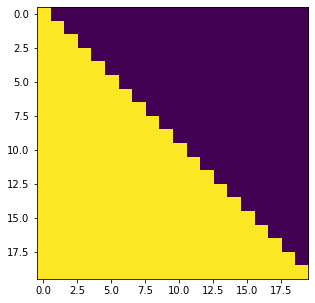

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

# 3.注意力机制

## 3.1.注意力
我们观察事物时，之所以能够快速判断一种事物(当然允许判断是错误的), 是因为我们大脑能够很快把注意力放在事物最具有辨识度的部分从而作出判断，而并非是从头到尾的观察一遍事物后，才能有判断结果. 正是基于这样的理论，就产生了注意力机制.

## 3.2.注意力计算规则
它需要三个指定的输入$Q(query)$, $K(key)$,$V(value)$, 然后通过公式得到注意力的计算结果, 这个结果代表query在key和value作用下的表示. 而这个具体的计算规则有很多种, 我这里只介绍我们用到的这一种.

$$
Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

假如我们有一个问题: 给出一段文本，使用一些关键词对它进行描述!为了方便统一正确答案，这道题可能预先已经写出了一些关键词作为提示.其中这些给出的提示就可以看作是key， 而整个的文本信息就相当于是query，value的含义则更抽象，可以比作是你看到这段文本信息后，脑子里浮现的答案信息，这里我们又假设大家最开始都不是很聪明，第一次看到这段文本后脑子里基本上浮现的信息就只有提示这些信息，因此key与value基本是相同的，但是随着我们对这个问题的深入理解，通过我们的思考脑子里想起来的东西原来越多，并且能够开始对我们query也就是这段文本，提取关键信息进行表示.  这就是注意力作用的过程， 通过这个过程，我们最终脑子里的value发生了变化，根据提示key生成了query的关键词表示方法，也就是另外一种特征表示方法.刚刚我们说到key和value一般情况下默认是相同，与query是不同的，这种是我们一般的注意力输入形式，但有一种特殊情况，就是我们query与key和value相同，这种情况我们称为自注意力机制，就如同我们的刚刚的例子， 使用一般注意力机制，是使用不同于给定文本的关键词表示它. 而自注意力机制,需要用给定文本自身来表达自己，也就是说你需要从给定文本中抽取关键词来表述它, 相当于对文本自身的一次特征提取.

## 3.3.注意力机制
注意力机制是注意力计算规则能够应用的深度学习网络的载体, 除了注意力计算规则外, 还包括一些必要的全连接层以及相关张量处理, 使其与应用网络融为一体. 使用自注意力计算规则的注意力机制称为自注意力机制.

![images](images/029.png)

In [5]:
input = torch.autograd.Variable(torch.randn(5, 5))
input

tensor([[ 2.2594,  1.2167, -0.4878,  0.4976,  0.8593],
        [-1.8731,  0.3004, -0.8478, -0.9652, -1.5069],
        [ 1.4263,  1.0552, -1.3266,  0.1995,  2.6404],
        [ 0.6596,  0.8923, -2.4125, -1.5468, -0.1726],
        [ 0.5612,  0.0828, -1.2075,  0.4097, -0.3580]])

In [6]:
mask = torch.autograd.Variable(torch.zeros(5, 5))
mask

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [7]:
input.masked_fill(mask == 0, -1e9)

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [8]:
from lib.PositionalEncoding import PositionalEncoding
from lib.Embeddings import Embeddings
from lib.Attention import attention

d_model = 512 # 词嵌入维度是512维
vocab = 1000# 词表大小是1000
x = torch.autograd.Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]])) # 输入x是一个使用Variable封装的长整型张量, 形状是2 x 4
emb = Embeddings(d_model, vocab)
embr = emb(x)

dropout = 0.1 # 置0比率为0.1
max_len=60 # 句子最大长度
x = embr
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)
query = key = value = pe_result
attn, p_attn = attention(query, key, value)
print("attn:", attn)
print("p_attn:", p_attn)

attn: tensor([[[ 15.0258,   8.0364,  15.1160,  ...,  -3.3893,  11.6157,  -5.7277],
         [-25.6366, -15.9603,  18.5502,  ...,   0.0000,  19.6376, -10.2258],
         [  0.0000,   0.0000,  21.2937,  ..., -26.0253, -10.0401,  -2.6868],
         [ 29.3873,   0.0000,  13.3779,  ...,  52.2231,  -9.2056, -33.0383]],

        [[  1.6617,  24.7486, -11.6641,  ..., -35.0158,   0.0000,  17.3508],
         [ 55.8104,  -5.6255,   4.1666,  ...,  -2.1684,  46.8155,  18.1351],
         [ 93.1199,  55.2154,  47.2830,  ..., -30.7171,  -7.7014,  27.6765],
         [ 33.9643, -20.3226, -28.1388,  ...,  16.3863,  -1.1394,  22.7751]]],
       grad_fn=<UnsafeViewBackward>)
p_attn: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward>)


In [9]:
query = key = value = pe_result

# 令mask为一个2x4x4的零张量
mask = torch.autograd.Variable(torch.zeros(2, 4, 4))
attn, p_attn = attention(query, key, value, mask=mask)
print("attn:", attn)
print("p_attn:", p_attn)

attn: tensor([[[  4.6942,  -1.9810,  17.0844,  ...,   5.7021,   3.0019, -12.9197],
         [  4.6942,  -1.9810,  17.0844,  ...,   5.7021,   3.0019, -12.9197],
         [  4.6942,  -1.9810,  17.0844,  ...,   5.7021,   3.0019, -12.9197],
         [  4.6942,  -1.9810,  17.0844,  ...,   5.7021,   3.0019, -12.9197]],

        [[ 46.1391,  13.5040,   2.9117,  ..., -12.8788,   9.4937,  21.4844],
         [ 46.1391,  13.5040,   2.9117,  ..., -12.8788,   9.4937,  21.4844],
         [ 46.1391,  13.5040,   2.9117,  ..., -12.8788,   9.4937,  21.4844],
         [ 46.1391,  13.5040,   2.9117,  ..., -12.8788,   9.4937,  21.4844]]],
       grad_fn=<UnsafeViewBackward>)
p_attn: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 

# 4.多头注意力机制
从多头注意力的结构图中，貌似这个所谓的多个头就是指多组线性变换层，其实并不是，只有使用了一组线性变化层，即三个变换张量对Q，K，V分别进行线性变换，这些变换不会改变原有张量的尺寸，因此每个变换矩阵都是方阵，得到输出结果后，多头的作用才开始显现，每个头开始从词义层面分割输出的张量，也就是每个头都想获得一组Q，K，V进行注意力机制的计算，但是句子中的每个词的表示只获得一部分，也就是只分割了最后一维的词嵌入向量. 这就是所谓的多头，将每个头的获得的输入送到注意力机制中, 就形成多头注意力机制.

![images](images/030.png)

In [10]:
from lib.MultiHeadedAttention import MultiHeadedAttention

# 头数head
head = 8

# 词嵌入维度embedding_dim
embedding_dim = 512

# 置零比率dropout
dropout = 0.2
# 假设输入的Q，K，V仍然相等
query = value = key = pe_result

# 输入的掩码张量mask
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))
mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)

tensor([[[  2.6518,   5.5778,   0.0689,  ...,  -0.4410,  -2.3415,   5.0106],
         [  0.3030,   2.3861,   0.5803,  ...,  -2.9160,   0.5175,   2.1776],
         [  2.8040,   4.3131,  -0.7991,  ...,   0.3299,  -1.4044,   3.1119],
         [  0.9429,  -0.9946,  -0.1604,  ...,   3.7631,  -4.1479,   1.9265]],

        [[ -6.7589,  -9.6749,   3.9519,  ...,  -2.4641,   0.7034,   0.0604],
         [ -4.2012, -11.4498,   2.9996,  ...,  -3.3334,  -2.1496,   2.5971],
         [ -6.7732,  -9.7686,   4.3320,  ...,  -5.2262,   0.9100,  -2.6310],
         [ -7.0776, -10.1681,   2.3223,  ...,  -1.7299,   0.6082,   4.5347]]],
       grad_fn=<AddBackward0>)


- 多头注意力机制:
    - 每个头开始从词义层面分割输出的张量，也就是每个头都想获得一组Q，K，V进行注意力机制的计算，但是句子中的每个词的表示只获得一部分，也就是只分割了最后一维的词嵌入向量. 这就是所谓的多头.将每个头的获得的输入送到注意力机制中, 就形成了多头注意力机制.
- 多头注意力机制的作用:
    - 这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果.
- 实现了多头注意力机制的类: MultiHeadedAttention
    - 因为多头注意力机制中需要使用多个相同的线性层, 首先实现了克隆函数clones.
    - clones函数的输入是module，N，分别代表克隆的目标层，和克隆个数.
    - clones函数的输出是装有N个克隆层的Module列表.
    - 接着实现MultiHeadedAttention类, 它的初始化函数输入是h, d_model, dropout分别代表头数，词嵌入维度和置零比率.
    - 它的实例化对象输入是Q, K, V以及掩码张量mask.
    - 它的实例化对象输出是通过多头注意力机制处理的Q的注意力表示.

# 5.前馈全连接层

## 5.1.前馈全连接层
在Transformer中前馈全连接层就是具有两层线性层的全连接网络.

## 5.2.前馈全连接层的作用
考虑注意力机制可能对复杂过程的拟合程度不够, 通过增加两层网络来增强模型的能力.

In [11]:
from lib.PositionwiseFeedForward import PositionwiseFeedForward
d_model = 512
# 线性变化的维度
d_ff = 64
dropout = 0.2
x = mha_result
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result)

tensor([[[ 1.2527,  0.3683,  1.3200,  ...,  0.9640, -0.6376, -0.4171],
         [-0.2730,  1.3092,  2.2593,  ..., -0.5786, -0.0913, -0.2911],
         [ 0.4396,  0.8270,  2.0878,  ...,  0.4099, -0.6176,  0.1170],
         [-0.4021,  1.0899,  3.0212,  ..., -0.3452, -0.9432, -1.5087]],

        [[ 2.6249, -0.0102,  0.7391,  ...,  2.5496, -1.7434, -3.6331],
         [ 3.3073,  0.0708,  0.5323,  ...,  3.5287, -1.9094, -1.6386],
         [ 2.4557,  0.6948, -0.6274,  ...,  3.6380, -2.1658, -1.1532],
         [ 1.5157, -0.0956, -0.8481,  ...,  2.3237, -3.4699, -2.5981]]],
       grad_fn=<AddBackward0>)


# 6.规范化层
它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常的慢. 因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内.

In [12]:
from lib.LayerNorm import LayerNorm

features = d_model = 512
eps = 1e-6
x = ff_result
ln = LayerNorm(features, eps)
ln_result = ln(x)
print(ln_result)

tensor([[[ 1.4361,  0.4953,  1.5077,  ...,  1.1290, -0.5749, -0.3403],
         [-0.2261,  1.2867,  2.1950,  ..., -0.5183, -0.0524, -0.2433],
         [ 0.6258,  1.0902,  2.6019,  ...,  0.5902, -0.6416,  0.2391],
         [-0.2523,  1.0061,  2.6352,  ..., -0.2043, -0.7087, -1.1856]],

        [[ 1.6483,  0.0471,  0.5025,  ...,  1.6026, -1.0060, -2.1542],
         [ 2.1735,  0.1175,  0.4107,  ...,  2.3142, -1.1404, -0.9684],
         [ 1.5944,  0.4745, -0.3664,  ...,  2.3463, -1.3447, -0.7007],
         [ 1.0015,  0.0057, -0.4593,  ...,  1.5008, -2.0796, -1.5408]]],
       grad_fn=<AddBackward0>)


# 7.子层连接结构
输入到每个子层以及规范化层的过程中，还使用了残差链接（跳跃连接），因此我们把这一部分结构整体叫做子层连接（代表子层及其链接结构），在每个编码器层中，都有两个子层，这两个子层加上周围的链接结构就形成了两个子层连接结构.

![images](images/031.png)  ![images](images/032.png)

In [13]:
from lib.MultiHeadedAttention import MultiHeadedAttention
from lib.SublayerConnection import SublayerConnection
size = 512
dropout = 0.2
head = 8
d_model = 512
# 令x为位置编码器的输出
x = pe_result
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))

# 假设子层中装的是多头注意力层, 实例化这个类
self_attn =  MultiHeadedAttention(head, d_model)

# 使用lambda获得一个函数类型的子层
sublayer = lambda x: self_attn(x, x, x, mask)
sc = SublayerConnection(size, dropout)
sc_result = sc(x, sublayer)
print(sc_result)
print(sc_result.shape)

tensor([[[ 15.1067,   7.8620,  15.2091,  ...,  -3.3893,  11.5510,  -5.8564],
         [-25.5126, -16.1701,  18.5116,  ...,  -0.2279,  19.4917, -10.3415],
         [  0.1472,  -0.2130,  21.3320,  ..., -26.1354, -10.1490,  -2.6868],
         [ 29.4363,  -0.3045,  13.1850,  ...,  52.1794,  -9.3446, -33.1388]],

        [[  1.7231,  24.7486, -11.6557,  ..., -35.2455,  -0.1286,  17.3508],
         [ 55.8633,  -5.6491,   4.3722,  ...,  -2.3203,  46.6268,  18.3316],
         [ 93.2670,  55.2894,  47.3759,  ..., -30.8440,  -7.6692,  27.6765],
         [ 33.9643, -20.3598, -28.1388,  ...,  16.1753,  -1.2813,  23.0741]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


# 8.编码器层
作为编码器的组成单元, 每个编码器层完成一次对输入的特征提取过程, 即编码过程.

![images](images/033.png)

In [14]:
from lib.MultiHeadedAttention import MultiHeadedAttention
from lib.PositionwiseFeedForward import PositionwiseFeedForward
from lib.EncoderLayer import EncoderLayer
size = 512
head = 8
d_model = 512
d_ff = 64
x = pe_result
dropout = 0.2
self_attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))

el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)
print(el_result)
print(el_result.shape)

tensor([[[ 1.4645e+01,  7.6673e+00,  1.4996e+01,  ..., -3.2609e+00,
           1.1972e+01, -5.9493e+00],
         [-2.5577e+01, -1.6736e+01,  1.7808e+01,  ..., -4.7880e-01,
           2.0479e+01, -1.0190e+01],
         [ 4.2206e-03, -5.7985e-01,  2.1082e+01,  ..., -2.5989e+01,
          -9.8385e+00, -2.7872e+00],
         [ 2.9509e+01, -1.0259e-01,  1.3378e+01,  ...,  5.2219e+01,
          -8.7093e+00, -3.2861e+01]],

        [[ 1.0879e+00,  2.5385e+01, -1.2962e+01,  ..., -3.5016e+01,
           3.4716e-01,  1.7283e+01],
         [ 5.5810e+01, -5.5063e+00,  3.1003e+00,  ..., -1.4800e+00,
           4.7385e+01,  1.8292e+01],
         [ 9.3163e+01,  5.5126e+01,  4.7173e+01,  ..., -3.0988e+01,
          -8.5355e+00,  2.7762e+01],
         [ 3.3671e+01, -2.0333e+01, -2.8879e+01,  ...,  1.5715e+01,
          -1.3606e+00,  2.2800e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


# 9.编码器
编码器用于对输入进行指定的特征提取过程, 也称为编码, 由N个编码器层堆叠而成.

![images](images/034.png)

In [16]:
from lib.MultiHeadedAttention import MultiHeadedAttention
from lib.PositionwiseFeedForward import PositionwiseFeedForward
from lib.EncoderLayer import EncoderLayer
from lib.Encoder import Encoder
import copy
# 第一个实例化参数layer, 它是一个编码器层的实例化对象, 因此需要传入编码器层的参数
# 又因为编码器层中的子层是不共享的, 因此需要使用深度拷贝各个对象.
size = 512
head = 8
d_model = 512
d_ff = 64
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
dropout = 0.2
layer = EncoderLayer(size, c(attn), c(ff), dropout)

# 编码器中编码器层的个数N
N = 8
mask = torch.autograd.Variable(torch.zeros(8, 4, 4))

en = Encoder(layer, N)
en_result = en(x, mask)
print(en_result)
print(en_result.shape)

tensor([[[ 8.0421e-01,  2.0448e-01,  6.9661e-01,  ..., -1.3006e-01,
           5.0433e-01, -2.9646e-01],
         [-8.4901e-01, -7.1930e-01,  8.3998e-01,  ...,  1.8372e-01,
           8.8645e-01, -3.9564e-01],
         [-5.5599e-03, -1.1633e-01,  8.6820e-01,  ..., -1.0176e+00,
          -2.9405e-01, -1.7876e-01],
         [ 1.3911e+00, -1.4005e-01,  4.4955e-01,  ...,  2.3076e+00,
          -3.3113e-01, -1.5053e+00]],

        [[ 1.4914e-01,  8.5155e-01, -3.6431e-01,  ..., -1.5363e+00,
          -1.1590e-01,  6.4684e-01],
         [ 2.7025e+00,  4.5692e-03,  4.2180e-01,  ...,  2.2123e-03,
           2.0656e+00,  1.0070e+00],
         [ 3.8703e+00,  2.2815e+00,  2.0192e+00,  ..., -1.3379e+00,
          -2.4570e-01,  1.2335e+00],
         [ 1.4576e+00, -8.9819e-01, -1.0635e+00,  ...,  6.9472e-01,
          -1.5115e-01,  9.1170e-01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])
